In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import random
random.seed(12)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import cv2

import math

# metric learning
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

## Dataset

In [4]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape(48,48,1)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))

#             X = torch.cat((X,X,X),0)

        return X, y

In [5]:
batch_size= 128

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# CLAHE preprocessing
def clahe(x):
    x = np.array(x) # unit8
    x = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    x = x.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x)
    
    return x

train_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
#     transforms.RandomCrop((48,48)),
    transforms.RandomRotation(180),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Feature Act 5

In [7]:
import math
class FeatureAct(nn.Module):
    def __init__(self, src_feature, target_feature):
        super(FeatureAct, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        self.src_conv = nn.Sequential(nn.Conv2d(src_feature, src_feature, kernel_size=(3,3), stride=1, padding=1),
                                      nn.BatchNorm2d(src_feature), nn.ReLU(inplace=True))

        # pool to fix H and W size
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, src_x, target_x):
        
        src_feature = self.src_conv(src_x)
        
        src_gap = self.gap(src_x)
        src_gap = nn.Flatten()(src_gap)

        target_gap = self.gap(target_x)
        target_gap = nn.Flatten()(target_gap)

        cor = torch.bmm(src_gap.unsqueeze(-1), target_gap.unsqueeze(1))
        sm_cor = cor / torch.norm(cor)

        cor_feature = torch.cat([(src_feature * sm_cor[:, :, k, None, None]).sum(1).unsqueeze(1) for k in range(target_gap.size(1))], dim=1)

        cor_feature = self.pool(cor_feature)

        target_x = target_x * (1 + cor_feature)

        return target_x

In [8]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64)
        self.fact1_2 = FeatureAct(64, 128)
        self.fact2_3 = FeatureAct(128, 256)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3 = self.fact2_3(x2, x3)
        
        x_emb = nn.Flatten()(xfact2_3)
        x = self.classifier(x_emb)
        
        return x, x_emb

In [9]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

def attention(model, img, lb=None, visual_heatmap=True):
    model.eval()
    output, _ = model(img.unsqueeze(0))
    prob = nn.Softmax()(output.detach())
    prob = float(prob.max(1)[0][0])
    
    
    pred_lb = int(output.argmax(1)[0])
    
    lb = pred_lb if lb is None else lb
    output[:,lb].backward()

    # get gradient
    grads = gradients['last_conv'][0]
    
    # !!! 2 options
#     pooled_grads = torch.mean(grads, dim=[0, 2, 3])
    pooled_grads = torch.nn.functional.adaptive_avg_pool2d(grads, (1, 1))

    # get activation
    features = activation['last_conv']

    # weight the channels by corresponding gradients
    for i in range(features.size(1)):
        features[:, i, :, :] *= pooled_grads[0,i,:,:]
   
    heatmap = features.detach().numpy()
    heatmap = np.mean(heatmap, axis=1).squeeze()
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
 
    img = img.numpy()[0]
    img = np.stack((img,)*3, axis=-1)
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # Adjust the size of the heat map to be the same as the original image
    heatmap = np.uint8(255 * heatmap) # Convert the heat map to RGB format
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Apply the heat map to the original image
    heatmap = heatmap[:,:,::-1]
    superimposed_img = heatmap * 0.008 + img # here 0.4 is the heat map intensity factor
        
    superimposed_img /= np.max(superimposed_img)
    
        
    return superimposed_img, pred_lb, int(lb), prob



In [26]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

gradients = {}
def get_gradient(name):
    def hook(model, in_grad, out_grad):
        gradients[name] = out_grad
        
    return hook

model = torch.load('./feature_act_5_tripletloss_model.pt')
model = model.cpu()
model.eval()

# print(model)

model.fact2_3.register_forward_hook(get_activation('last_conv'))
model.fact2_3.register_backward_hook(get_gradient('last_conv'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the

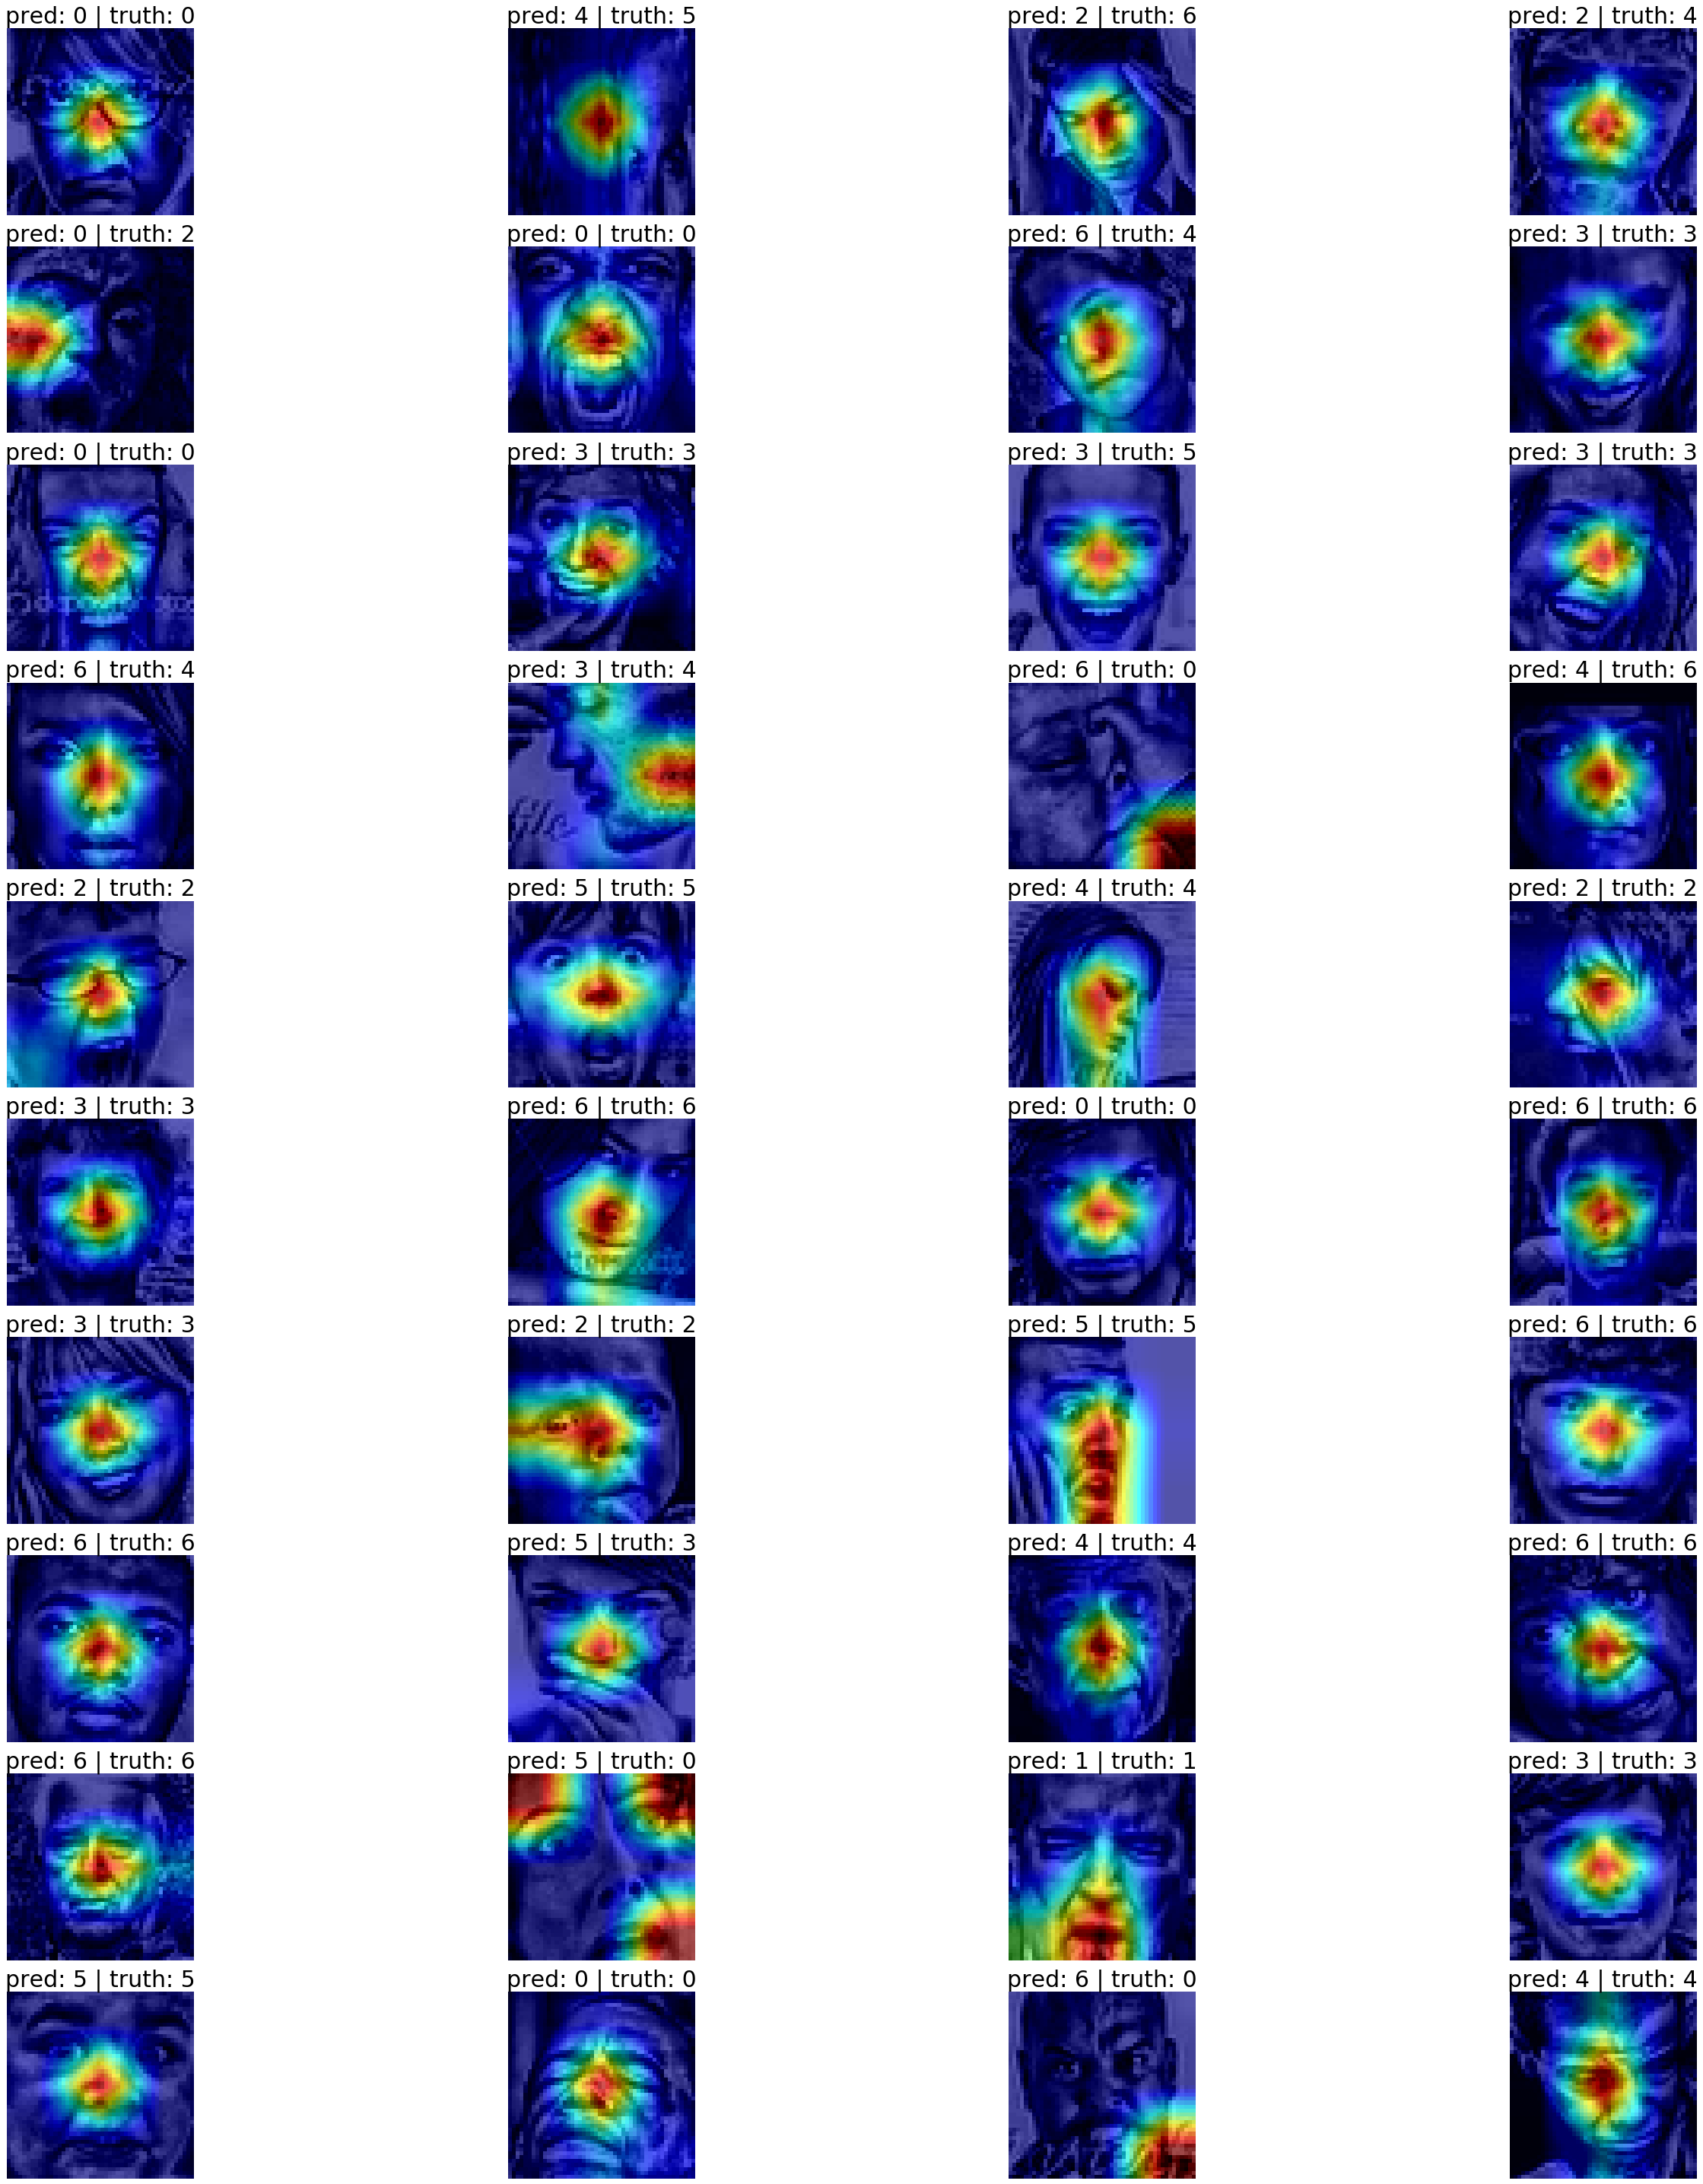

In [91]:
%matplotlib inline

images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
        try:
            map, pred, truth, prob = attention(model, images[id], labels[id])
            axs[i,j].imshow(map)
            axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
            axs[i,j].axis('off')
            id = id + 1
        except:
            break

plt.tight_layout()
plt.show()

### Feature Act 6

In [36]:
import math
class FeatureAct(nn.Module):
    def __init__(self, src_feature, target_feature):
        super(FeatureAct, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        self.src_conv = nn.Sequential(nn.Conv2d(src_feature, src_feature, kernel_size=(3,3), stride=1, padding=1),
                                      nn.BatchNorm2d(src_feature), nn.ReLU(inplace=True))

        # pool to fix H and W size
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, src_x, target_x):
        
        src_feature = self.src_conv(src_x)
        
        src_gap = self.gap(src_x)
        src_gap = nn.Flatten()(src_gap)

        target_gap = self.gap(target_x)
        target_gap = nn.Flatten()(target_gap)

        cor = torch.bmm(src_gap.unsqueeze(-1), target_gap.unsqueeze(1))
        sm_cor = cor / torch.norm(cor)

        cor_feature = torch.cat([(src_feature * sm_cor[:, :, k, None, None]).sum(1).unsqueeze(1) for k in range(target_gap.size(1))], dim=1)

        cor_feature = self.pool(cor_feature)

        target_x = target_x * (1 + cor_feature)

        return target_x, nn.Flatten()(cor_feature)

In [37]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64)
        self.fact1_2 = FeatureAct(64, 128)
        self.fact2_3 = FeatureAct(128, 256)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1, cf0 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2, cf1 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3, cf2 = self.fact2_3(x2, x3)
        
        x_classifier = nn.Flatten()(xfact2_3)
        x_emb = torch.cat([x_classifier, cf0, cf1, cf2], dim=1)
        x = self.classifier(x_classifier)
        
        return x, x_emb

In [38]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

In [39]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output[0].detach()
    return hook

gradients = {}
def get_gradient(name):
    def hook(model, in_grad, out_grad):
        gradients[name] = out_grad
        
    return hook

model = torch.load('./feature_act_6_tripletloss_model.pt')
model = model.cpu()
model.eval()

# print(model)

model.fact2_3.register_forward_hook(get_activation('last_conv'))
model.fact2_3.register_backward_hook(get_gradient('last_conv'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the

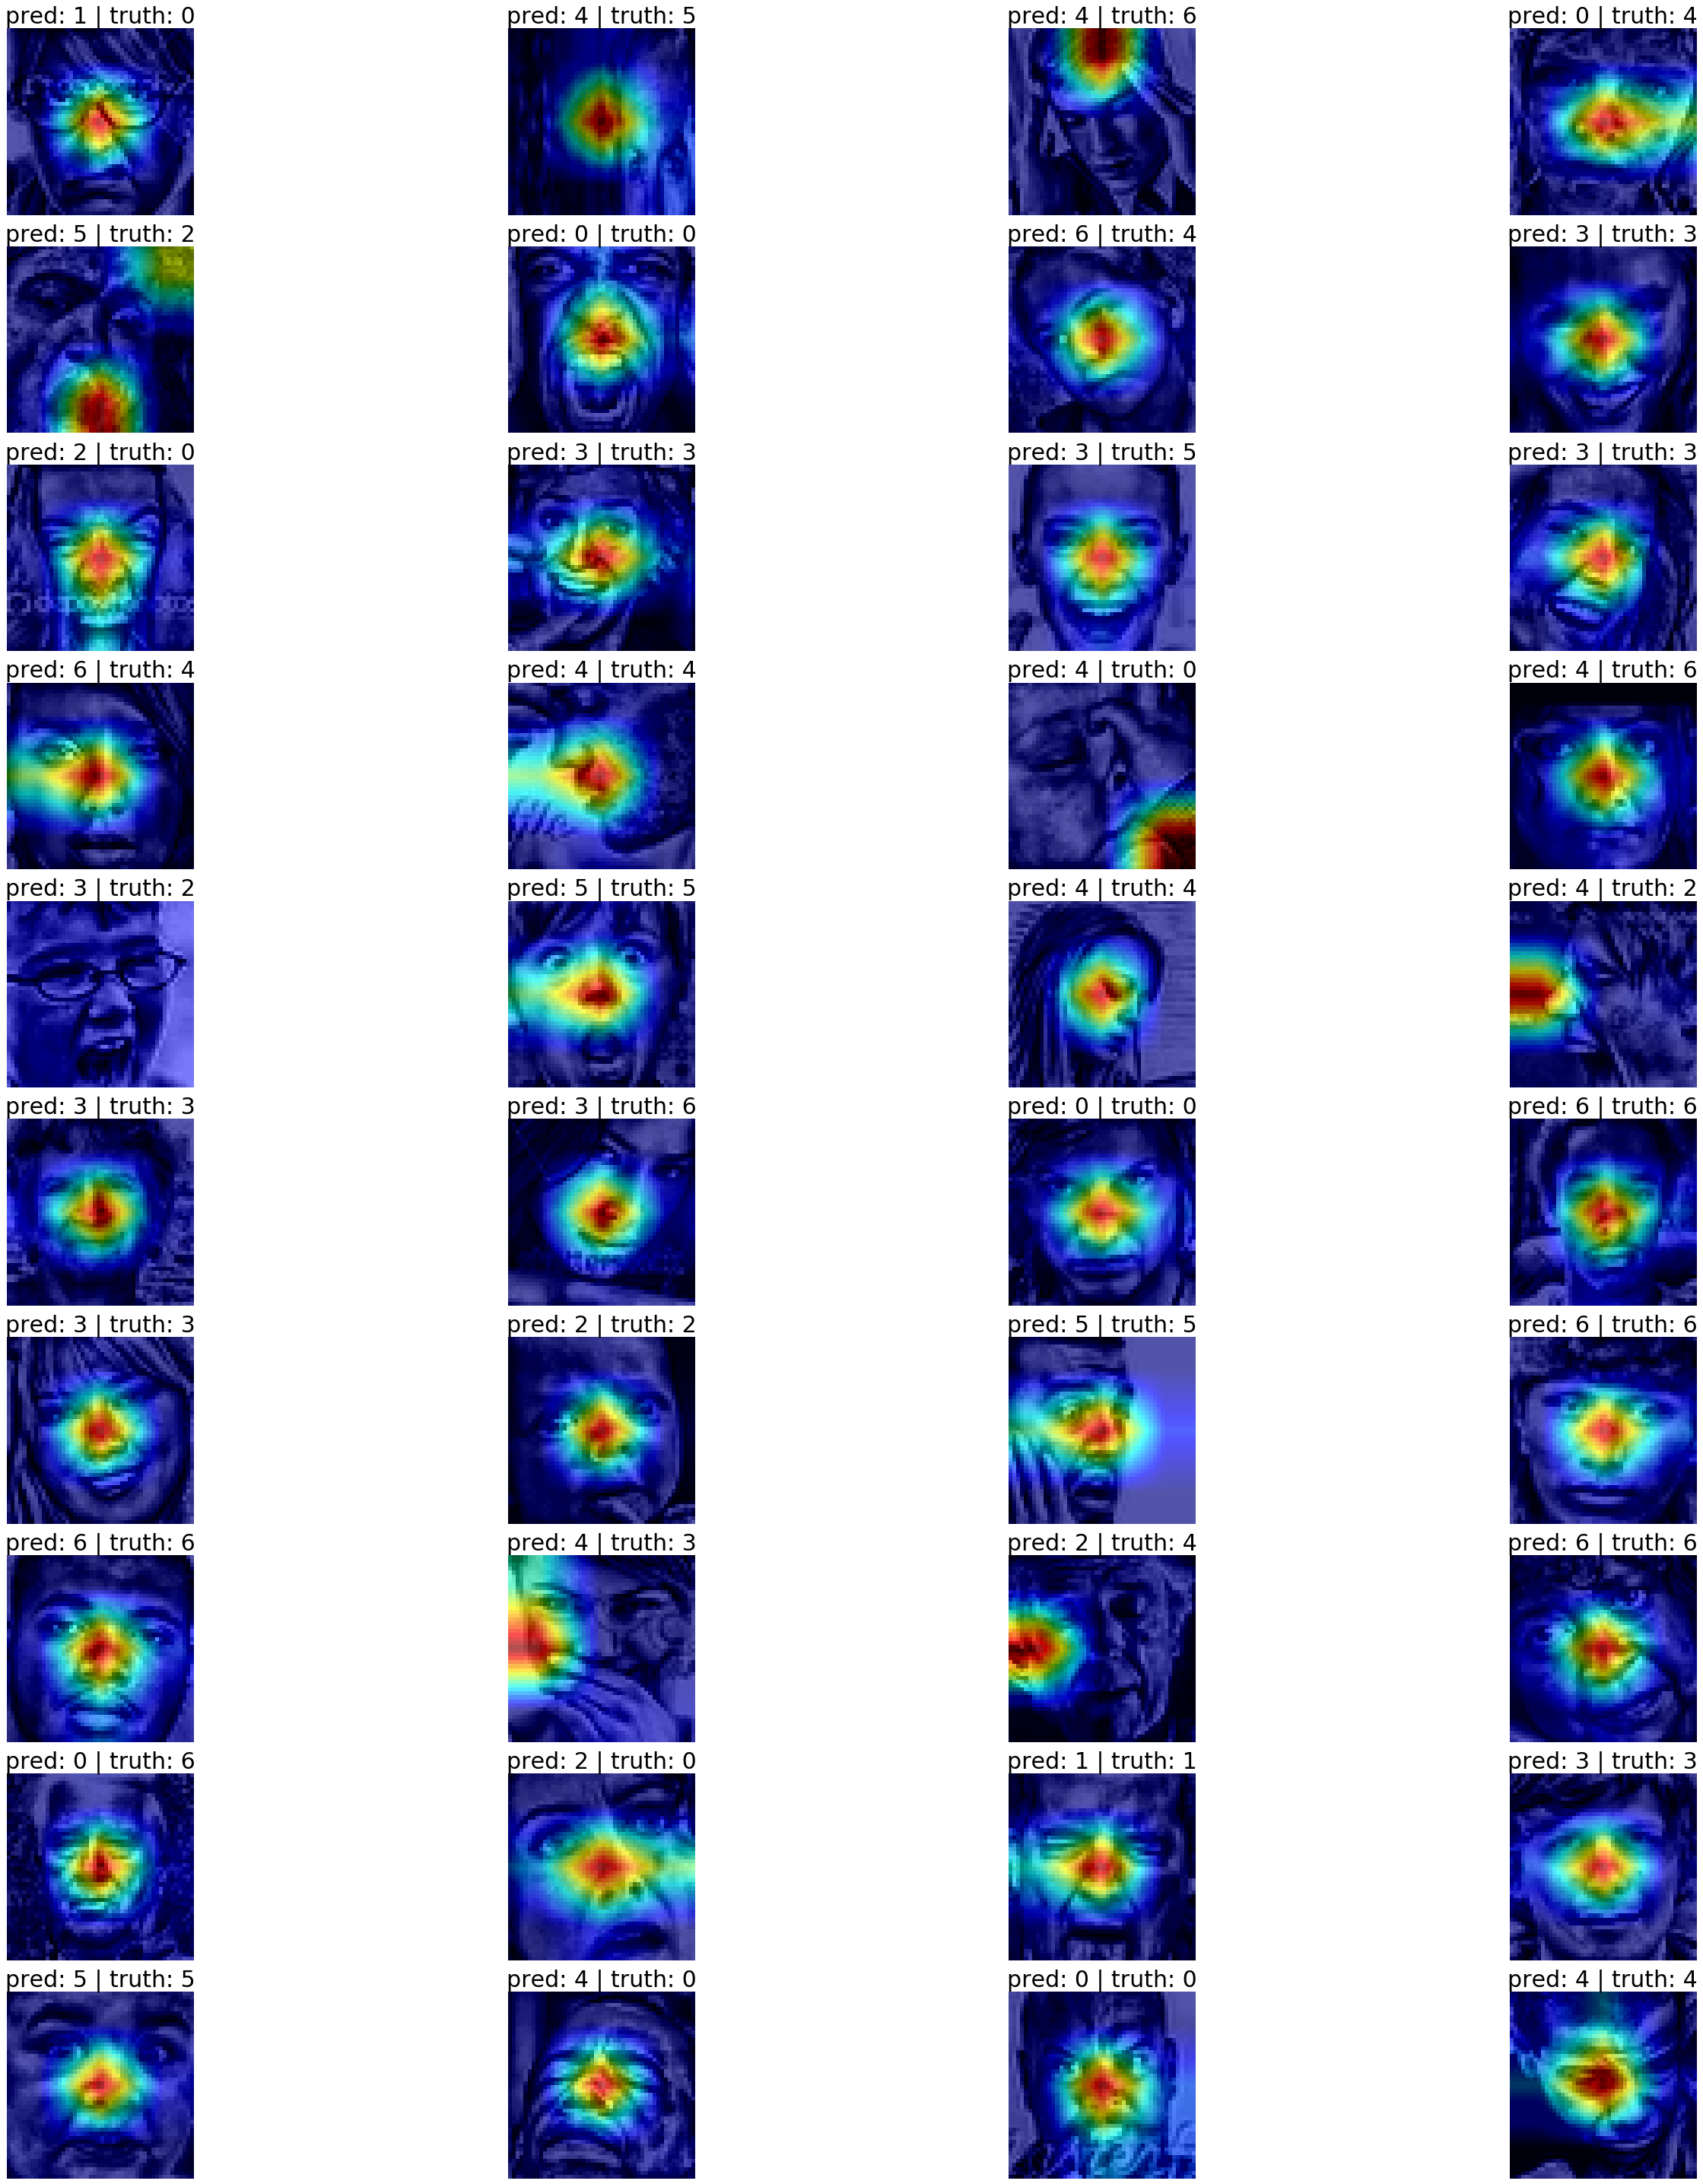

In [42]:
%matplotlib inline

images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
        try:
            map, pred, truth, prob = attention(model.cpu(), images[id], labels[id])
            axs[i,j].imshow(map)
            axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
            axs[i,j].axis('off')
            id = id + 1
        except:
            break

plt.tight_layout()
plt.show()

In [40]:
map, pred, truth, prob = attention(model.cpu(), images[id], labels[id])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


IndexError: too many indices for tensor of dimension 3

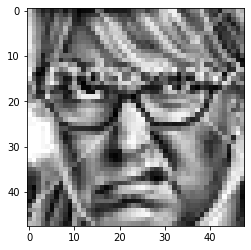

In [46]:
plt.imshow(images[0][0,:,:], cmap='gray')

In [63]:
images, labels = iter(test_loader).next()
images

tensor([[[[-1.0000, -1.0000,  0.0039,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000,  0.0745,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.0196,  ..., -0.7647, -0.7255, -0.6706],
          ...,
          [ 0.6627,  0.7255,  0.8275,  ..., -0.4667, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.1686, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ...,  0.3333, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.000

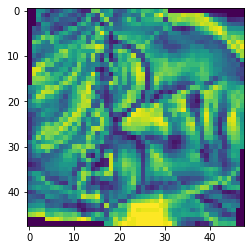

In [68]:
sample = images[0]
sample = nn.ZeroPad2d((0,0,0,0))(sample)
sample = sample[:,:48,:48]
plt.imshow(sample[0])

In [70]:
map, pred, truth, prob = attention(model.cpu(), sample, labels[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x7fe97221dc88>, 4, 0)

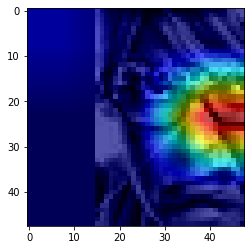

In [55]:
plt.imshow(map), pred, truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x7fe97211da20>, 3, 0)

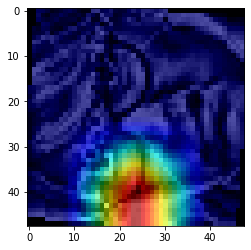

In [71]:
plt.imshow(map), pred, truth

### LBP

In [50]:
from skimage.feature import local_binary_pattern

batch_size= 128

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

# df_train = df[df['Usage'] == 'Training']
# df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# CLAHE preprocessing
def clahe(x):
    x = np.array(x) # unit8
    x = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    x = x.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x)
    
    # lbp
    radius = 2
    n_points = 8 * radius
    METHOD = 'uniform'
    _x = local_binary_pattern(x, n_points, radius, method=METHOD)
    _x = 1 / (1 + np.exp(-_x))
    
    x = x * _x
    x = x.astype(np.uint8)
    
    return x



test_transforms = transforms.Compose([
    transforms.Lambda(clahe),
#     transforms.Lambda(lbp_transform),
    transforms.ToPILImage(),
#     transforms.RandomCrop((48,48)),
#     transforms.RandomRotation(180),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_set = FERDataset(df_test, test_transforms)


test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


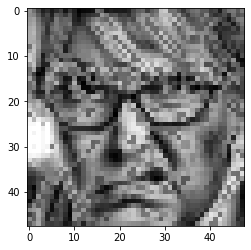

In [51]:
images, labels = iter(test_loader).next()
sample = images[0]
# sample = nn.ZeroPad2d((0,0,0,0))(sample)
# sample = sample[:,:48,:48]
plt.imshow(sample[0], cmap='gray')

In [46]:
images, labels = iter(test_loader).next()
sample = images[0]
# sample = nn.ZeroPad2d((0,0,0,0))(sample)
# sample = sample[:,:48,:48]
plt.imshow(sample[0], cmap='gray')

IndexError: index 1 is out of bounds for dimension 0 with size 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x7fa3dbf6fb38>, 4, 0)

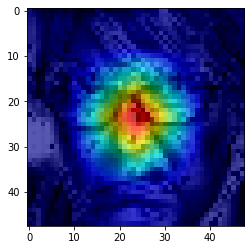

In [45]:
map, pred, truth, prob = attention(model.cpu(), sample, labels[0])
plt.imshow(map), pred, truth